In [1]:
import cv2
import os
import numpy as np
from matplotlib import colors
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
import sys
sys.path.append('/content/drive/MyDrive/siamese-registration')

from datasets import RandomTransformationDataset
from models import *
from utils import get_transformation_matrix

In [4]:
path = "/content/drive/MyDrive/data"
output_path = "/content/drive/MyDrive/outputs"

In [5]:
test_dataset = RandomTransformationDataset(
    transforms=transforms.Compose([
        transforms.ToTensor(),
    ]),
    path=os.path.join(path, "test.pkl"),
    path_prefix="/content/drive/MyDrive"
)

In [6]:
test_loader = DataLoader(test_dataset, batch_size=1, num_workers=10, shuffle=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [7]:
checkpoint = "model-9.pt"
model = siamese_resnet18(1, 7)
model.load_state_dict(torch.load(os.path.join(output_path, checkpoint), map_location=device))
model.cuda()
model.eval()

print(f"Running on {device}")

Running on cuda


In [13]:
loader = iter(test_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [39]:
import time


img0, img1, params = next(loader)
img0, img1, params = img0.to(device=device), img1.to(device=device), params.to(device=device)

start = time.perf_counter()
outputs = model(img0, img1)
end = time.perf_counter()

inference = end - start

image0 = img0.detach().cpu().numpy()[0, 0, :, :]
image1 = img1.detach().cpu().numpy()[0, 0, :, :]
rows, cols = image0.shape
center = (cols//2, rows//2)

tx, ty, sx, sy, shx, shy, q = outputs.detach().cpu().numpy().reshape(-1).tolist()
start = time.perf_counter()
matrix = get_transformation_matrix(center, tx, ty, sx, sy, shx, shy, q)
matrix_opencv = np.float32(matrix.flatten()[:6].reshape(2, 3))
inverse_matrix = cv2.invertAffineTransform(matrix_opencv)
inversed_image1 = cv2.warpAffine(image1, inverse_matrix, (cols, rows))
end = time.perf_counter()

registration = end - start


print(f"inference: {inference*1000:.3f} ms \nregistration: {registration*1000:.3f} ms")

inference: 13.415 ms 
registration: 2.911 ms


In [40]:
param_list = []
output_list = []

with tqdm(test_loader) as validation_progress:
    for img0, img1, params in validation_progress:
        img0, img1, params = img0.to(device=device), img1.to(device=device), params.to(device=device)
        outputs = model(img0, img1)
        param_list.append(params.detach().cpu().numpy().reshape(-1).tolist())
        output_list.append(outputs.detach().cpu().numpy().reshape(-1).tolist())

  0%|          | 0/8000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
  1%|▏         | 100/8000 [00:14<19:38,  6.70it/s]


KeyboardInterrupt: ignored

In [ ]:
import json
import pandas as pd
import numpy as np

In [ ]:
d = {'params':param_list, 'outputs':output_list}

In [ ]:
df = pd.DataFrame(d, columns=['params','outputs'])

In [ ]:
df.to_csv(os.path.join("/content/drive/MyDrive/outputs", "outputs.csv"))

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/outputs/outputs.csv")

In [ ]:
df.outputs = df.outputs.apply(lambda x: np.array(json.loads(x)))
df.params = df.params.apply(lambda x: np.array(json.loads(x)))

In [ ]:
df['comp'] = np.abs(df['outputs'] - df['params'])
df['comp_percentage'] = np.divide(df['comp'], abs(df['params']))*100

In [ ]:
(abs(6.719-6.955)/6.955)*100

3.3932422717469413

In [ ]:
df2 = pd.DataFrame(df['comp'].to_list(), columns = ['tx', 'ty', 'sx', 'sy', 'shx', 'shy', 'q'])
df3 = pd.DataFrame(df['comp_percentage'].to_list(), columns = ['tx', 'ty', 'sx', 'sy', 'shx', 'shy', 'q'])

In [ ]:
df2

,tx,ty,sx,sy,shx,shy,q
0,0.236735,1.242702,0.042870,0.028101,0.085463,0.041966,0.046033
1,4.040718,30.879852,0.010252,0.086970,0.146555,0.092403,0.038320
2,10.275426,1.092071,0.033698,0.064159,0.006251,0.111867,0.147306
3,3.450596,6.146397,0.005182,0.017803,0.060699,0.068052,0.093368
4,1.616991,8.012047,0.018538,0.019675,0.016891,0.025264,0.009046
...,...,...,...,...,...,...,...
7995,3.625030,1.796547,0.014180,0.014282,0.023991,0.069556,0.056253
7996,3.210281,1.098763,0.018714,0.025562,0.034366,0.002860,0.084368
7997,11.741301,0.963469,0.004925,0.034689,0.052995,0.010551,0.001331
7998,5.854997,7.241923,0.005154,0.028914,0.022961,0.032363,0.029693


In [ ]:
df3

,tx,ty,sx,sy,shx,shy,q
0,3.523335,6.527101,4.414231,2.757413,112.588718,57.263340,63.011438
1,8.241161,65.522436,1.024686,8.289105,175.596407,123.836615,40.279703
2,77.982990,48.830207,3.515523,6.197641,30.201458,204.602520,1049.735885
3,14.117601,307.759755,0.519653,1.818414,88.227960,113.186694,88.633375
4,18.337222,18.461080,1.893245,1.939227,53.604703,31.856051,22.390851
...,...,...,...,...,...,...,...
7995,25.017864,6.715559,1.412232,1.461752,63.321301,78.745064,92.171873
7996,9.787134,2.476526,1.784356,2.690000,476.764808,17.231343,88.875047
7997,29.255308,6.832900,0.477311,3.590650,103.438100,106.051917,11.184889
7998,51.525343,38.601711,0.515122,2.857802,245.833605,301.931336,20.854481


In [ ]:
df2.insert(7, "q_deg", df2.q.apply(lambda x: np.degrees(x)))

In [ ]:
df2

,tx,ty,sx,sy,shx,shy,q,q_deg
0,0.236735,1.242702,0.042870,0.028101,0.085463,0.041966,0.046033,2.637495
1,4.040718,30.879852,0.010252,0.086970,0.146555,0.092403,0.038320,2.195559
2,10.275426,1.092071,0.033698,0.064159,0.006251,0.111867,0.147306,8.440040
3,3.450596,6.146397,0.005182,0.017803,0.060699,0.068052,0.093368,5.349565
4,1.616991,8.012047,0.018538,0.019675,0.016891,0.025264,0.009046,0.518298
...,...,...,...,...,...,...,...,...
7995,3.625030,1.796547,0.014180,0.014282,0.023991,0.069556,0.056253,3.223062
7996,3.210281,1.098763,0.018714,0.025562,0.034366,0.002860,0.084368,4.833941
7997,11.741301,0.963469,0.004925,0.034689,0.052995,0.010551,0.001331,0.076271
7998,5.854997,7.241923,0.005154,0.028914,0.022961,0.032363,0.029693,1.701269


In [ ]:
df2.describe()

,tx,ty,sx,sy,shx,shy,q
count,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,6.633702,8.167822,0.025623,0.027611,0.050134,0.048725,0.086865
std,6.608164,7.915253,0.017439,0.020407,0.033103,0.032673,0.057322
min,0.002094,0.002056,0.000009,0.000002,0.000008,0.000006,0.000017
25%,2.115572,2.682322,0.011117,0.011562,0.023105,0.021718,0.039723
50%,4.715327,5.885535,0.023280,0.024343,0.045576,0.044166,0.079518
75%,8.834183,11.022942,0.037361,0.039670,0.073004,0.070792,0.126572
max,71.347382,65.330605,0.105059,0.213494,0.175791,0.172551,0.314017


In [ ]:
df3.describe()

,tx,ty,sx,sy,shx,shy,q
count,8000.000000,8000.000000,8000.000000,8000.000000,8.000000e+03,8000.000000,8000.000000
mean,118.990462,122.829928,2.564297,2.749023,4.725175e+02,321.208037,222.305319
std,2620.392232,1138.483397,1.747972,2.012286,1.949588e+04,4895.823603,1425.978851
min,0.008561,0.006744,0.000897,0.000164,4.517978e-02,0.013657,0.031222
25%,9.558764,12.498194,1.113168,1.166766,6.381560e+01,57.270572,61.508344
50%,22.638429,28.392084,2.328842,2.436841,1.002464e+02,96.909648,97.069409
75%,49.444469,60.818058,3.756396,3.952241,1.495153e+02,148.678877,144.200810
max,222265.092433,59240.048380,10.995044,22.409367,1.736276e+06,386623.128169,65222.252668


In [ ]:
df2.describe().to_latex()

'\\begin{tabular}{lrrrrrrrr}\n\\toprule\n{} &           tx &           ty &           sx &           sy &          shx &          shy &            q &        q\\_deg \\\\\n\\midrule\ncount &  8000.000000 &  8000.000000 &  8000.000000 &  8000.000000 &  8000.000000 &  8000.000000 &  8000.000000 &  8000.000000 \\\\\nmean  &     6.633702 &     8.167822 &     0.025623 &     0.027611 &     0.050134 &     0.048725 &     0.086865 &     4.977010 \\\\\nstd   &     6.608164 &     7.915253 &     0.017439 &     0.020407 &     0.033103 &     0.032673 &     0.057322 &     3.284331 \\\\\nmin   &     0.002094 &     0.002056 &     0.000009 &     0.000002 &     0.000008 &     0.000006 &     0.000017 &     0.000989 \\\\\n25\\%   &     2.115572 &     2.682322 &     0.011117 &     0.011562 &     0.023105 &     0.021718 &     0.039723 &     2.275949 \\\\\n50\\%   &     4.715327 &     5.885535 &     0.023280 &     0.024343 &     0.045576 &     0.044166 &     0.079518 &     4.556023 \\\\\n75\\%   &     8.83418

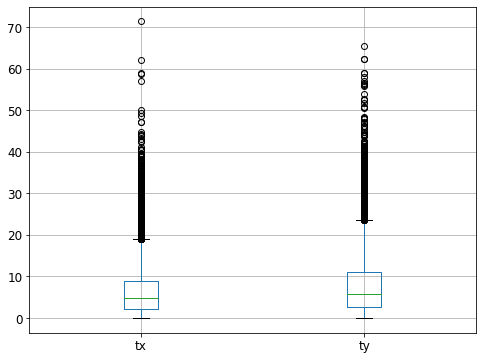

In [ ]:
plt.figure(figsize=(8,6))
boxplot = df2.boxplot(column = ['tx', 'ty',], fontsize="large")
plt.savefig(os.path.join("/content/drive/MyDrive/plots", "t.png"))

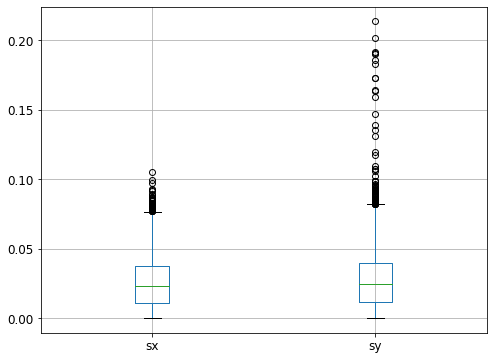

In [ ]:
plt.figure(figsize=(8,6))
boxplot = df2.boxplot(column = ['sx', 'sy',], fontsize="large")
plt.savefig(os.path.join("/content/drive/MyDrive/plots", "s.png"))

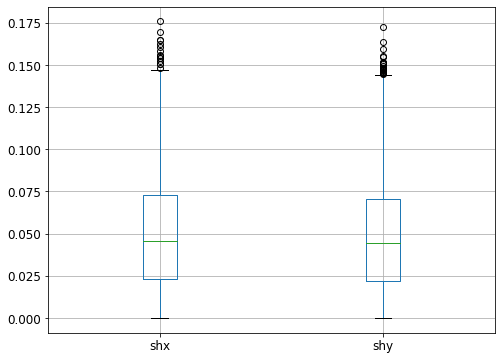

In [ ]:
plt.figure(figsize=(8,6))
boxplot = df2.boxplot(column = ['shx', 'shy',], fontsize="large")
plt.savefig(os.path.join("/content/drive/MyDrive/plots", "sh.png"))

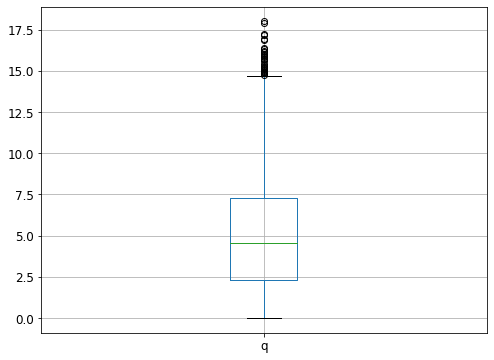

In [ ]:
plt.figure(figsize=(8,6))
boxplot = df2.boxplot(column = ['q'], fontsize="large")
plt.savefig(os.path.join("/content/drive/MyDrive/plots", "q.png"))

In [ ]:
plt.savefig(os.path.join("/content/drive/MyDrive/plots", "q.png"))

<Figure size 432x288 with 0 Axes>